In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/NLP'

/content/drive/MyDrive/Colab Notebooks/NLP


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data = pd.read_csv('data/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
classes = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

data['all'] = data[classes].sum(axis=1)
data['any'] = data['all'].apply(lambda x:1 if x>0 else 0)

In [ ]:
datatrain, datatest = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation) + ["\'m"] + ["\'s"] + ["\'\'"] + ["``"] + ["n\'t"] + ["ca"]

In [ ]:
lem = WordNetLemmatizer()
def clean_data(txt):
    txt = nltk.word_tokenize(txt.lower())
    txt = [word for word in txt if not word in useless_words]
    txt = [lem.lemmatize(w, "v") for w in txt]
    return ' '.join(word for word in txt)

In [ ]:
datatest['comment_text'] = datatest['comment_text'].apply(lambda x:clean_data(x))
datatrain['comment_text'] = datatrain['comment_text'].apply(lambda x:clean_data(x))

In [ ]:
def ROC_curve_plot(datatest, prediction, classes, figure_title):
    # Compute ROC curve and ROC area for each class
    nbr_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y = np.zeros(nbr_classes*len(datatest))
    y_hat = np.zeros(nbr_classes*len(datatest))

    for idx,clas in enumerate(classes):
        print('... Processing {}'.format(clas))
        print('Cofusion Matrix:\n', confusion_matrix(datatest[clas], prediction[:,idx]))
        fpr[clas], tpr[clas], _ = roc_curve(datatest[clas], prediction[:,idx])
        roc_auc[clas] = auc(fpr[clas], tpr[clas])

        y[idx*len(datatest):(idx+1)*len(datatest)] = datatest[clas].values
        y_hat[idx*len(datatest):(idx+1)*len(datatest)] = prediction[:,idx]
        
    # Compute average ROC curve and ROC area
    fpr["all"], tpr["all"], _ = roc_curve(y, y_hat)
    roc_auc["all"] = auc(fpr["all"], tpr["all"])
    
    plt.figure(figsize=(10,10))
    for i in ["all"] + classes:
        plt.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate' , fontsize=12)
    plt.title(figure_title,           fontsize=12)
    plt.legend(loc="lower right",     fontsize=12)
    plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DecisionTree_pipeline = Pipeline([
                            ('tfidf', TfidfVectorizer()),
                            ('clf', OneVsRestClassifier(DecisionTreeClassifier())),
                           ])

DecisionTree_pipeline.fit(datatrain['comment_text'], datatrain[classes])
prediction = DecisionTree_pipeline.predict(datatest['comment_text'])

#ROC_curve_plot(datatest, prediction, classes, 'ROC curve : Decision Tree Classifier')

... Processing toxic
Cofusion Matrix:
 [[27993   866]
 [  923  2133]]
... Processing severe_toxic
Cofusion Matrix:
 [[31416   178]
 [  233    88]]
... Processing obscene
Cofusion Matrix:
 [[29847   353]
 [  427  1288]]
... Processing threat
Cofusion Matrix:
 [[31784    57]
 [   56    18]]
... Processing insult
Cofusion Matrix:
 [[29743   558]
 [  671   943]]
... Processing identity_hate
Cofusion Matrix:
 [[31497   124]
 [  191   103]]


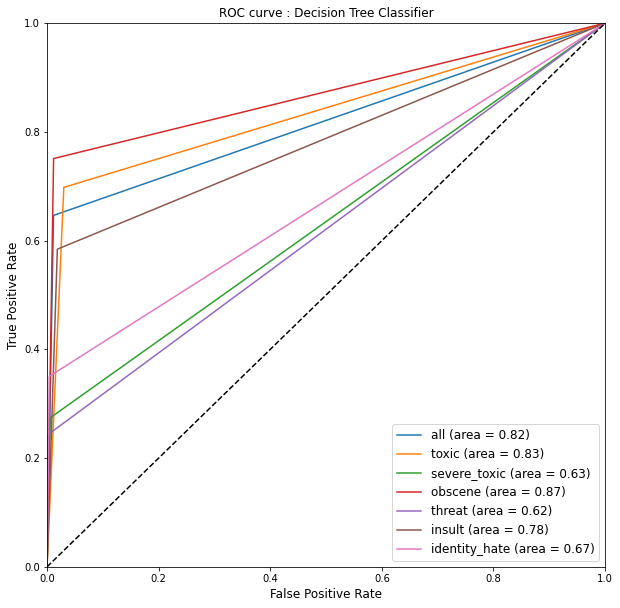

In [ ]:
ROC_curve_plot(datatest, prediction, classes, 'ROC curve : Decision Tree Classifier')

... Processing toxic
Cofusion Matrix:
 [[28555   304]
 [  943  2113]]
... Processing severe_toxic
Cofusion Matrix:
 [[31512    82]
 [  221   100]]
... Processing obscene
Cofusion Matrix:
 [[30044   156]
 [  502  1213]]
... Processing threat
Cofusion Matrix:
 [[31824    17]
 [   56    18]]
... Processing insult
Cofusion Matrix:
 [[30055   246]
 [  676   938]]
... Processing identity_hate
Cofusion Matrix:
 [[31589    32]
 [  216    78]]


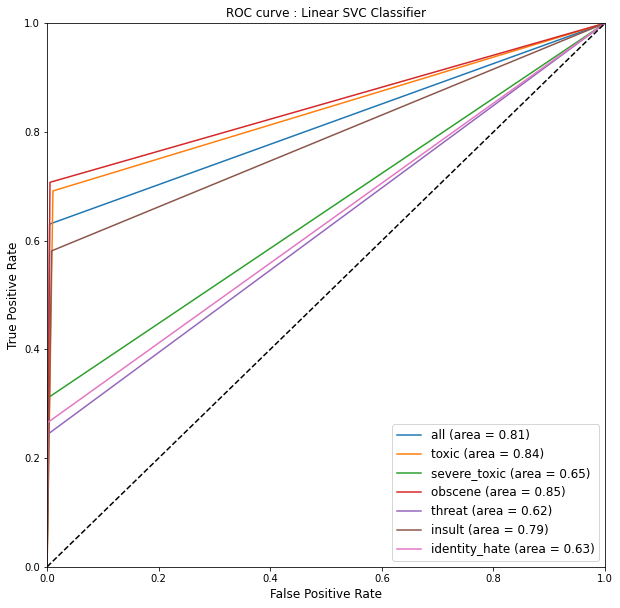

In [ ]:
SVC_pipeline = Pipeline([
                         ('tfidf', TfidfVectorizer()),
                         ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                        ])

SVC_pipeline.fit(datatrain['comment_text'], datatrain[classes])
prediction = SVC_pipeline.predict(datatest['comment_text'])

ROC_curve_plot(datatest, prediction, classes, 'ROC curve : Linear SVC Classifier')
